<trimesh.Trimesh(vertices.shape=(844, 3), faces.shape=(2234, 3), name=`chair_0001.off`)>


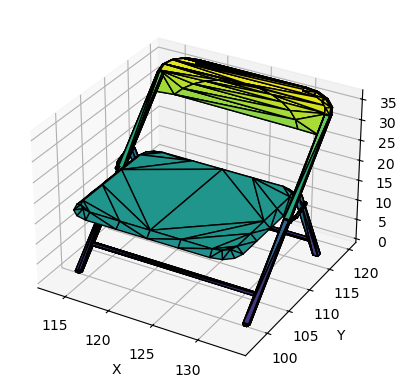

(1000, 3)


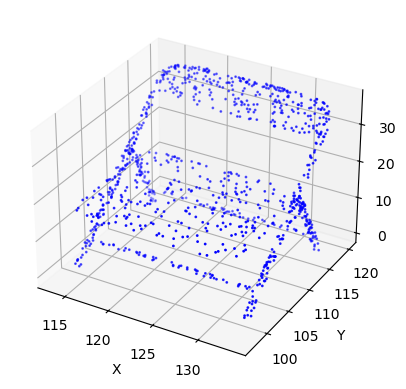

In [5]:
import trimesh
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

# Path to the downloaded ModelNet40 dataset (in .off or .obj format)
modelnet_path = "datasets/ModelNet40"

# Load a specific category (e.g., "chair")
category = "chair"

# Load a specific object file (example)
file_name = os.path.join(modelnet_path, category, "train", "chair_0001.off")

# Load the 3D shape using trimesh (for .off files)
mesh = trimesh.load_mesh(file_name)
print(mesh)
mesh.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract vertices and faces
vertices = mesh.vertices
faces = mesh.faces

# Plot the mesh using Matplotlib
ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces, cmap='viridis', edgecolor='k')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.savefig('mesh.pdf', bbox_inches='tight', pad_inches=0)
# Show plot
plt.show()

# Sample points from the mesh surface (e.g., 1000 points)
num_points_to_sample = 1000
sampled_points = mesh.sample(num_points_to_sample)
print(sampled_points.shape)
# Plot the sampled points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the sampled points
ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], color='b', s=1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.savefig('graph.pdf', bbox_inches='tight', pad_inches=0)

# Show plot
plt.show()

<>:143: SyntaxWarning: invalid escape sequence '\s'
<>:143: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rf/fxvb25cs2g3gswh_tlqb19j80000gn/T/ipykernel_86420/1150307519.py:143: SyntaxWarning: invalid escape sequence '\s'
  """


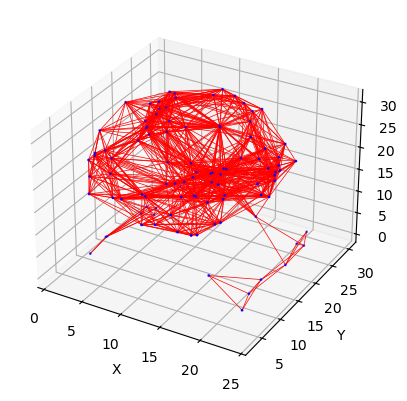

torch.Size([1, 1, 100])
torch.Size([5, 1, 3, 1]) 1.2687019
torch.Size([1, 1, 100])
torch.Size([5, 1, 3, 1]) 0.0


In [6]:
import trimesh
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree
import networkx as nx
import math

import torch.nn as nn

class GraphFilter(nn.Module):
    """
    GraphFilter Creates a (linear) layer that applies a graph filter

    Initialization:

        GraphFilter(in_features, out_features, filter_taps,
                    edge_features=1, bias=True)

        Inputs:
            in_features (int): number of input features (each feature is a graph
                signal)
            out_features (int): number of output features (each feature is a
                graph signal)
            filter_taps (int): number of filter taps
            edge_features (int): number of features over each edge
            bias (bool): add bias vector (one bias per feature) after graph
                filtering

        Output:
            torch.nn.Module for a graph filtering layer (also known as graph
            convolutional layer).

        Observation: Filter taps have shape
            out_features x edge_features x filter_taps x in_features

    Add graph shift operator:

        GraphFilter.addGSO(GSO) Before applying the filter, we need to define
        the GSO that we are going to use. This allows to change the GSO while
        using the same filtering coefficients (as long as the number of edge
        features is the same; but the number of nodes can change).

        Inputs:
            GSO (torch.tensor): graph shift operator; shape:
                edge_features x number_nodes x number_nodes

    Forward call:

        y = GraphFilter(x)

        Inputs:
            x (torch.tensor): input data; shape:
                batch_size x in_features x number_nodes

        Outputs:
            y (torch.tensor): output; shape:
                batch_size x out_features x number_nodes
    """

    def __init__(self, G, F, K, E = 1, bias = True):
        # K: Number of filter taps
        # GSOs will be added later.
        # This combines both weight scalars and weight vectors.
        # Bias will always be shared and scalar.

        # Initialize parent
        super().__init__()
        # Save parameters:
        self.G = G
        self.F = F
        self.K = K
        self.E = E
        self.S = None # No GSO assigned yet
        # Create parameters:
        self.weight = nn.parameter.Parameter(torch.Tensor(F, E, K, G))
        if bias:
            self.bias = nn.parameter.Parameter(torch.Tensor(F, 1))
        else:
            self.register_parameter('bias', None)
        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        # Taken from _ConvNd initialization of parameters:
        stdv = 1. / math.sqrt(self.G * self.K)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def set_parameters(self, params):
        # Taken from _ConvNd initialization of parameters:
        # stdv = 1. / math.sqrt(self.G * self.K)
        # self.weight.data.uniform_(-stdv, stdv)
        # if self.bias is not None:
            # self.bias.data.uniform_(-stdv, stdv)
        assert self.weight.shape == params.shape
        self.weight.data = params

    def addGSO(self, S):
        # Every S has 3 dimensions.
        assert len(S.shape) == 3
        # S is of shape E x N x N
        assert S.shape[0] == self.E
        self.N = S.shape[1]
        assert S.shape[2] == self.N
        self.S = S

    def forward(self, x):
        # x is of shape: batchSize x dimInFeatures x numberNodesIn
        B = x.shape[0]
        F = x.shape[1]
        Nin = x.shape[2]
        # And now we add the zero padding
        if Nin < self.N:
            x = torch.cat((x,
                           torch.zeros(B, F, self.N-Nin)\
                                   .type(x.dtype).to(x.device)
                          ), dim = 2)
        # Compute the filter output
        u = LSIGF(self.weight, self.S, x, self.bias)
        # So far, u is of shape batchSize x dimOutFeatures x numberNodes
        # And we want to return a tensor of shape
        # batchSize x dimOutFeatures x numberNodesIn
        # since the nodes between numberNodesIn and numberNodes are not required
        if Nin < self.N:
            u = torch.index_select(u, 2, torch.arange(Nin).to(u.device))
        return u

    def extra_repr(self):
        reprString = "in_features=%d, out_features=%d, " % (
                        self.G, self.F) + "filter_taps=%d, " % (
                        self.K) + "edge_features=%d, " % (self.E) +\
                        "bias=%s, " % (self.bias is not None)
        if self.S is not None:
            reprString += "GSO stored"
        else:
            reprString += "no GSO stored"
        return reprString
    

def LSIGF(h, S, x, b=None):
    """
    LSIGF(filter_taps, GSO, input, bias=None) Computes the output of a linear
        shift-invariant graph filter on input and then adds bias.

    Denote as G the number of input features, F the number of output features,
    E the number of edge features, K the number of filter taps, N the number of
    nodes, S_{e} in R^{N x N} the GSO for edge feature e, x in R^{G x N} the
    input data where x_{g} in R^{N} is the graph signal representing feature
    g, and b in R^{F x N} the bias vector, with b_{f} in R^{N} representing the
    bias for feature f.

    Then, the LSI-GF is computed as
        y_{f} = \sum_{e=1}^{E}
                    \sum_{k=0}^{K-1}
                    \sum_{g=1}^{G}
                        [h_{f,g,e}]_{k} S_{e}^{k} x_{g}
                + b_{f}
    for f = 1, ..., F.

    Inputs:
        filter_taps (torch.tensor): array of filter taps; shape:
            output_features x edge_features x filter_taps x input_features
        GSO (torch.tensor): graph shift operator; shape:
            edge_features x number_nodes x number_nodes
        input (torch.tensor): input signal; shape:
            batch_size x input_features x number_nodes
        bias (torch.tensor): shape: output_features x number_nodes
            if the same bias is to be applied to all nodes, set number_nodes = 1
            so that b_{f} vector becomes b_{f} \mathbf{1}_{N}

    Outputs:
        output: filtered signals; shape:
            batch_size x output_features x number_nodes
    """
    # The basic idea of what follows is to start reshaping the input and the
    # GSO so the filter coefficients go just as a very plain and simple
    # linear operation, so that all the derivatives and stuff on them can be
    # easily computed.

    # h is output_features x edge_weights x filter_taps x input_features
    # S is edge_weighs x number_nodes x number_nodes
    # x is batch_size x input_features x number_nodes
    # b is output_features x number_nodes
    # Output:
    # y is batch_size x output_features x number_nodes

    # Get the parameter numbers:
    F = h.shape[0]
    E = h.shape[1]
    K = h.shape[2]
    G = h.shape[3]
    assert S.shape[0] == E
    N = S.shape[1]
    assert S.shape[2] == N
    B = x.shape[0]
    assert x.shape[1] == G
    assert x.shape[2] == N
    # Or, in the notation we've been using:
    # h in F x E x K x G
    # S in E x N x N
    # x in B x G x N
    # b in F x N
    # y in B x F x N

    # Now, we have x in B x G x N and S in E x N x N, and we want to come up
    # with matrix multiplication that yields z = x * S with shape
    # B x E x K x G x N.
    # For this, we first add the corresponding dimensions
    x = x.reshape([B, 1, G, N])
    S = S.reshape([1, E, N, N])
    z = x.reshape([B, 1, 1, G, N]).repeat(1, E, 1, 1, 1) # This is for k = 0
    # z = x.reshape(B, 1, 1, G, N).repeat(1, E, 1, G, N)
# Reshape and repeat x properly
    # z = x.unsqueeze(1).repeat(1, E, 1, 1, 1)

    # We need to repeat along the E dimension, because for k=0, S_{e} = I for
    # all e, and therefore, the same signal values have to be used along all
    # edge feature dimensions.
    for k in range(1,K):
        x = torch.matmul(x, S) # B x E x G x N
        xS = x.reshape([B, E, 1, G, N]) # B x E x 1 x G x N
        z = torch.cat((z, xS), dim = 2) # B x E x k x G x N
    # This output z is of size B x E x K x G x N
    # Now we have the x*S_{e}^{k} product, and we need to multiply with the
    # filter taps.
    # We multiply z on the left, and h on the right, the output is to be
    # B x N x F (the multiplication is not along the N dimension), so we reshape
    # z to be B x N x E x K x G and reshape it to B x N x EKG (remember we
    # always reshape the last dimensions), and then make h be E x K x G x F and
    # reshape it to EKG x F, and then multiply
    y = torch.matmul(z.permute(0, 4, 1, 2, 3).reshape([B, N, E*K*G]),
                     h.reshape([F, E*K*G]).permute(1, 0)).permute(0, 2, 1)
    # And permute againt to bring it from B x N x F to B x F x N.
    # Finally, add the bias
    if b is not None:
        y = y + b
    return y

def get_matrix_from_file(category, file_number, modelnet_path, number_of_points, epsilon):
    # Load a specific object file (example)
    file_name = os.path.join(modelnet_path, category, "train", f"{category}_{int(file_number):04}.off")

    # Load the 3D shape using trimesh (for .off files)
    mesh = trimesh.load_mesh(file_name)

    # Sample points from the mesh surface (e.g., 1000 points)
    # num_points_to_sample = 100
    sampled_points = mesh.sample(number_of_points)

    # Define epsilon (distance threshold) for neighborhood
    # epsilon = 10  # Adjust this value based on the scale of your mesh

    # Build a k-d tree for fast nearest neighbor search
    tree = cKDTree(sampled_points)

    # Find pairs of points within distance epsilon
    pairs = tree.query_pairs(epsilon)

    # Create a graph
    G = nx.Graph()

    # Add nodes (each node is a point in the sampled points)
    for i in range(number_of_points):
        G.add_node(i, pos=sampled_points[i])

    # Add edges (pairs of points within epsilon distance)
    for i, j in pairs:
        G.add_edge(i, j)

    # Get the adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(G).todense()

    return adjacency_matrix, G


# Path to the downloaded ModelNet40 dataset (in .off or .obj format)
modelnet_path = "datasets/ModelNet40"
number_of_points = 100
# Load a specific category (e.g., "chair")
category = "chair"
epsilon = 10

adjacency_matrix, G = get_matrix_from_file(category, 20, modelnet_path, number_of_points, epsilon)

# Optionally visualize the graph (3D plot of points and edges)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract positions of the points for plotting
pos = np.array([G.nodes[i]['pos'] for i in G.nodes])

# Plot the sampled points
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], color='b', s=1, label='Points')

# Plot the edges connecting points within epsilon distance
for edge in G.edges:
    point1 = G.nodes[edge[0]]['pos']
    point2 = G.nodes[edge[1]]['pos']
    ax.plot([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], color='r', lw=0.5)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show plot
plt.show()
E = 1
K = 3
Fh = 5
Batch = 1
G = 1
Fin = 1
filter = GraphFilter(Fin,Fh,K, E)
adjacency_matrix = adjacency_matrix[np.newaxis, :, :]
adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
filter.addGSO(adjacency_matrix)

input_signal = np.ones(Batch * number_of_points * Fin).reshape(Batch, Fin, number_of_points)
input_signal = torch.tensor(input_signal, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
print(input_signal.shape)
out = filter.forward(input_signal)

print(filter.weight.shape, np.linalg.norm(filter.weight.detach().numpy()))

params = torch.zeros_like(filter.weight)

filter.set_parameters(params)
print(input_signal.shape)
filter.forward(input_signal)
print(filter.weight.shape, np.linalg.norm(filter.weight.detach().numpy()))


first is done 1500.1065


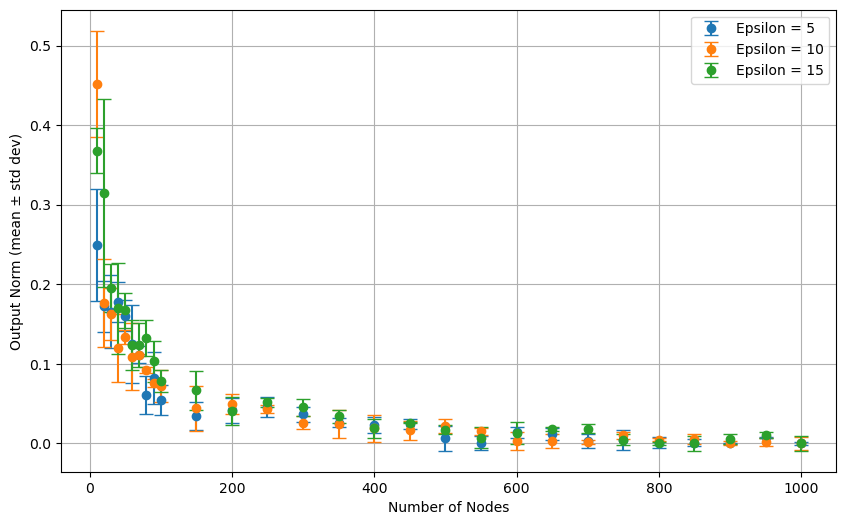

In [7]:
nNodes = [10,20,30,40,50,60,70,80,90,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
# nNodes = [10,20,30,40,50,60,70,80,90,100]

runs = 3
epsilon_list = [5,10,15]
out_norm = np.zeros([len(nNodes), runs])
E = 1
K = 3
Fh = 5
Batch = 1
G = 1
Fin = 1
epsilon = 10

number_of_points = nNodes[-1]
input_signal = np.ones(Batch * number_of_points * Fin).reshape(Batch, Fin, number_of_points)
input_signal = torch.tensor(input_signal, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor

adjacency_matrix, G = get_matrix_from_file(category, 20, modelnet_path, number_of_points, epsilon)

adjacency_matrix = adjacency_matrix[np.newaxis, :, :]
adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
filter = GraphFilter(Fin,Fh,K, E)
params = filter.weight

filter.addGSO(adjacency_matrix)
out = filter.forward(input_signal)
plt.figure(figsize=(10, 6))

print('first is done', torch.norm(out).item()/number_of_points)
for epsilon in epsilon_list:
    for idx, n in enumerate(nNodes):
        for run in range(runs):
            # print(n,idx, run)
            number_of_points = n
            input_signal = np.ones(Batch * number_of_points * Fin).reshape(Batch, Fin, number_of_points)
            input_signal = torch.tensor(input_signal, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
            epsilon_n = epsilon*np.log(n)/n
            adjacency_matrix, G = get_matrix_from_file(category, 20, modelnet_path, number_of_points, epsilon_n)
            adjacency_matrix = adjacency_matrix[np.newaxis, :, :]
            adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
            filter = GraphFilter(Fin,Fh,K, E)
            filter.set_parameters(params)
            # print
            filter.addGSO(adjacency_matrix)
            out = filter.forward(input_signal)
            out_norm[idx, run] = torch.norm(out).item() /number_of_points
            # print(n, torch.norm(out).item()/number_of_points)

    means = np.mean(out_norm, axis = 1)
    means = np.abs(means - means[-1])
    std_devs = np.std(out_norm, axis = 1)

    plt.errorbar(nNodes, means, yerr=std_devs, fmt='o', capsize=5, label=f'Epsilon = {epsilon}')
# plt.title('Means and Standard Deviation of Output Norms')
plt.xlabel('Number of Nodes')
plt.ylabel('Output Norm (mean ± std dev)')
plt.grid(True)
plt.legend()
plt.savefig('epsilon_generalization_gap.pdf')
plt.show()

tensor([[[[1],
          [2],
          [3]]]])
torch.Size([5, 1, 3, 1]) tensor(2.8542, grad_fn=<LinalgVectorNormBackward0>) tensor(1.2183, grad_fn=<LinalgVectorNormBackward0>)
first is done 0.040440906524658204
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
5

/var/folders/rf/fxvb25cs2g3gswh_tlqb19j80000gn/T/ipykernel_86420/4039282650.py:81: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(power_law, np.array([nNodes[1],nNodes[-1]]),


20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
20 14.978661367769954
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
30 11.337324605540518
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
40 9.22219863528484
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
50 7.824046010856292
60 6.823907603703501
60 6.823907603703501
60 6.823907603703501
60 6.823907603703501
60 6.823907603703501
60 6.823907603703501
60 6.823907603703501
60 6.823907603703501
60 6

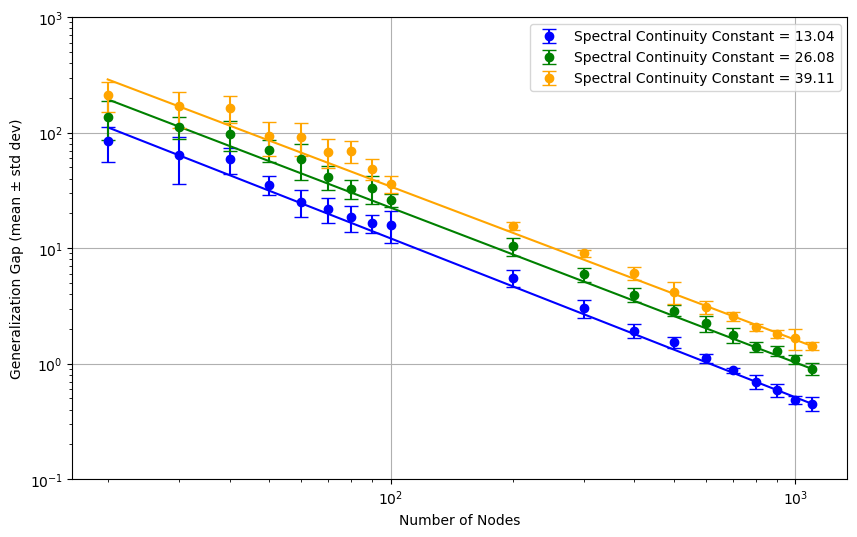

In [8]:
from scipy.optimize import curve_fit

fontsize_val = 18

def get_lipschitz_constant(params):
    indices = torch.arange(K).view(1, 1, K, 1)+1  # Shape (5, 1, 1, 1) to match broadcasting
    # Multiply the tensor by the index values
    x_weighted = params * indices

    # Compute the norm (by default, it computes the Frobenius norm, i.e., L2 norm)
    norm_result = torch.norm(x_weighted)
    return norm_result

def power_law(x, a, b):
    return a * (x ** b)

colors = ['blue', 'green', 'orange']

nNodes = [20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,1100]
params_list = [5,10,15]
runs = 10
epsilon = 10 
out_norm = np.zeros([len(nNodes), runs])
E = 1
K = 3
Fh = 5
Batch = 1
G = 1
Fin = 1
epsilon = 100

number_of_points = 2000
input_signal = np.ones(Batch * number_of_points * Fin).reshape(Batch, Fin, number_of_points)
input_signal = torch.tensor(input_signal, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor

epsilon_n = epsilon*np.log(number_of_points)/number_of_points
adjacency_matrix, G = get_matrix_from_file(category, 20, modelnet_path, number_of_points, epsilon_n)

adjacency_matrix = adjacency_matrix[np.newaxis, :, :]
adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
filter = GraphFilter(Fin,Fh,K, E)
params_original = filter.weight
indices = torch.arange(K).view(1, 1, K, 1)+1  # Shape (5, 1, 1, 1) to match broadcasting
print(indices)
# Multiply the tensor by the index values
x_weighted = params * indices

# Compute the norm (by default, it computes the Frobenius norm, i.e., L2 norm)
norm_result = torch.norm(x_weighted)
filter.addGSO(adjacency_matrix)
print(params.shape, norm_result, torch.norm(filter.weight))
out = filter.forward(input_signal)
plt.figure(figsize=(10, 6))
manifold = torch.norm(out).item()/number_of_points
print('first is done', torch.norm(out).item()/number_of_points)
for param_idx, param_multiplier in enumerate(params_list):
    params = params_original * param_multiplier
    for idx, n in enumerate(nNodes):
        for run in range(runs):
            # print(n,idx, run)
            number_of_points = n
            input_signal = np.ones(Batch * number_of_points * Fin).reshape(Batch, Fin, number_of_points)
            input_signal = torch.tensor(input_signal, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
            epsilon_n = epsilon*np.log(n)/n
            print(n,epsilon_n  )

            adjacency_matrix, G = get_matrix_from_file(category, 20, modelnet_path, number_of_points, epsilon_n)
            adjacency_matrix = adjacency_matrix[np.newaxis, :, :]
            adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
            filter = GraphFilter(Fin,Fh,K, E)
            filter.set_parameters(params)
            # print
            filter.addGSO(adjacency_matrix)
            out = filter.forward(input_signal)
            out_norm[idx, run] = torch.norm(out).item() /number_of_points
            # print(n, torch.norm(out).item()/number_of_points)

    means = np.mean(out_norm, axis = 1)
    means = np.abs(means - manifold)
    std_devs = np.std(out_norm, axis = 1)

    popt, pcov = curve_fit(power_law, np.array([nNodes[1],nNodes[-1]]), 
                           np.array([means[1],means[-1]]), maxfev=100000)
    fitted_means = power_law(np.array(nNodes), *popt)
    # plt.errorbar(nNodes, means, yerr=std_devs, fmt='o', capsize=5, label=f'Lischitz = {get_lipschitz_constant(params):.2f}')
    # plt.plot(nNodes, fitted_means)
    plt.errorbar(nNodes, means, yerr=std_devs, fmt='o', capsize=5, color=colors[param_idx], 
                 label=f'Spectral Continuity Constant = {get_lipschitz_constant(params):.2f}')
    plt.plot(nNodes, fitted_means, color=colors[param_idx])

# plt.title('Means and Standard Deviation of Output Norms')
plt.xlabel('Number of Nodes', fontsize=fontsize_val)
plt.ylabel('Generalization Gap (mean ± std dev)', fontsize=fontsize_val)
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1, 1e3)  # Adjust these values (e.g., 1e-1 and 1e3) to your desired range
plt.legend( fontsize=fontsize_val)
plt.savefig('lipschitz_generalization_gap.pdf')
plt.show()

tensor([[[[1],
          [2],
          [3]]]])
torch.Size([5, 1, 3, 1]) tensor(63.7425, grad_fn=<LinalgVectorNormBackward0>) tensor(1.3992, grad_fn=<LinalgVectorNormBackward0>)
first is done 0.06064532470703125


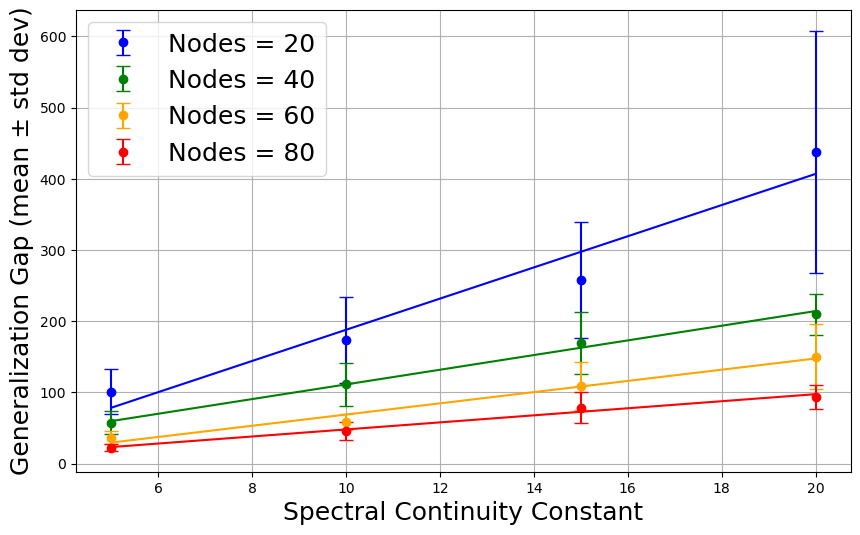

In [10]:
fontsize_val = 18

def get_lipschitz_constant(params):
    indices = torch.arange(K).view(1, 1, K, 1)+1  # Shape (5, 1, 1, 1) to match broadcasting
    # Multiply the tensor by the index values
    x_weighted = params * indices

    # Compute the norm (by default, it computes the Frobenius norm, i.e., L2 norm)
    norm_result = torch.norm(x_weighted)
    return norm_result
colors = ['blue', 'green', 'orange', 'red']

def power_law(x, a, b):
    return a+x*b


nNodes = [20,40,60,80]
params_list = [5,10,15,20]
runs = 10
epsilon = 10 
out_norm = np.zeros([len(params_list), runs])
E = 1
K = 3
Fh = 5
Batch = 1
G = 1
Fin = 1
epsilon = 100

number_of_points = 2000
input_signal = np.ones(Batch * number_of_points * Fin).reshape(Batch, Fin, number_of_points)
input_signal = torch.tensor(input_signal, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor

epsilon_n = epsilon*np.log(number_of_points)/number_of_points
adjacency_matrix, G = get_matrix_from_file(category, 20, modelnet_path, number_of_points, epsilon_n)

adjacency_matrix = adjacency_matrix[np.newaxis, :, :]
adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
filter = GraphFilter(Fin,Fh,K, E)
params_original = filter.weight
indices = torch.arange(K).view(1, 1, K, 1)+1  # Shape (5, 1, 1, 1) to match broadcasting
print(indices)
# Multiply the tensor by the index values
x_weighted = params * indices

# Compute the norm (by default, it computes the Frobenius norm, i.e., L2 norm)
norm_result = torch.norm(x_weighted)
filter.addGSO(adjacency_matrix)
print(params.shape, norm_result, torch.norm(filter.weight))
out = filter.forward(input_signal)
plt.figure(figsize=(10, 6))
manifold = torch.norm(out).item()/number_of_points
print('first is done', torch.norm(out).item()/number_of_points)

for idx_nodes, n in enumerate(nNodes):
    for idx, param_multiplier in enumerate(params_list):
        params = params_original * param_multiplier
        for run in range(runs):
            # print(n,idx, run)
            number_of_points = n
            input_signal = np.ones(Batch * number_of_points * Fin).reshape(Batch, Fin, number_of_points)
            input_signal = torch.tensor(input_signal, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
            epsilon_n = epsilon*np.log(n)/n
            # print(n,epsilon_n  )

            adjacency_matrix, G = get_matrix_from_file(category, 20, modelnet_path, number_of_points, epsilon_n)
            adjacency_matrix = adjacency_matrix[np.newaxis, :, :]
            adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
            filter = GraphFilter(Fin,Fh,K, E)
            filter.set_parameters(params)
            # print
            filter.addGSO(adjacency_matrix)
            out = filter.forward(input_signal)
            out_norm[idx, run] = torch.norm(out).item() /number_of_points
            # print(n, torch.norm(out).item()/number_of_points)

    means = np.mean(out_norm, axis = 1)
    means = np.abs(means - manifold)
    std_devs = np.std(out_norm, axis = 1)
    # print(means.shape, std_devs.shape, len(params_list))
    plt.errorbar(params_list, means, yerr=std_devs, fmt='o', capsize=5, label=f'Nodes = {int(number_of_points)}', color = colors[idx_nodes])
    # plt.plot(params_list, means ,  fmt='o', capsize=5, label=f'Nodes = {int(number_of_points)}')
    # plt.plot(means, params_list, marker='o', label=f'Nodes = {int(number_of_points)}')

    popt, pcov = curve_fit(power_law, np.array(params_list), 
                           np.array(means), maxfev=100000)
    fitted_means = power_law(np.array(params_list), *popt)
    plt.plot(params_list, fitted_means, color=colors[idx_nodes])

# plt.title('Means and Standard Deviation of Output Norms')
plt.xlabel('Spectral Continuity Constant', fontsize=fontsize_val)
plt.ylabel('Generalization Gap (mean ± std dev)', fontsize=fontsize_val)
plt.grid(True)

plt.legend(fontsize=fontsize_val)
plt.savefig('nodes_generalization_gap.pdf')
plt.show()